In [2]:
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import pandas as pd
import math
import matplotlib.pyplot as plt
import pylab
from IPython.display import Image
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16.0, 9.0)
import warnings

# Klimawandel und Migration

##Welche Entwicklungen sind zu erwarten?

###Julian Kuhlmann

*HPK Geburtstagssymposium 2015*

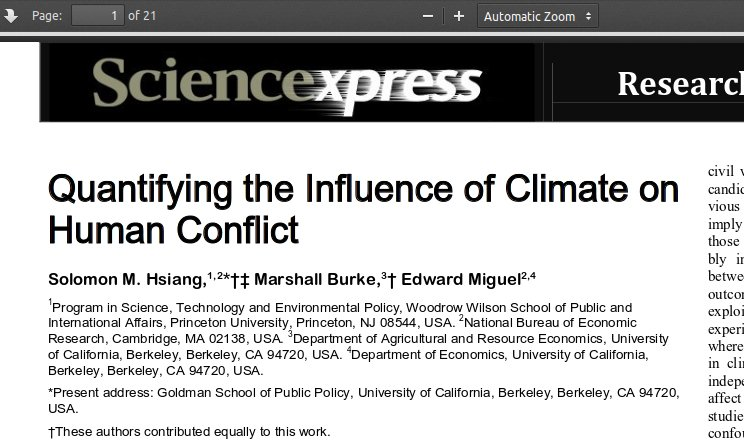

In [3]:
Image(filename='./resources/science_paper.jpg', width=650)

*"...a cross-sectional study might compare average rates of civil conflict, attributing observed differences to the different climate - despite the fact that there are clearly many other relevant ways in which the countries differ..."*

*"...it is likely impossible that any cross-sectional study can explicitly account for all important differences between populations..."*

*"...the difficulty in this setting is that climatic variables affect many of the socioeconomic factors commonly included as control variables..."*

In [4]:
class Country():
    def __init__(self, iso, name, geometry):
        self.iso = iso
        self.name = name
        self.geometry = geometry
        self.properties = {}
    def __str__(self):
        return self.iso
    def __repr__(self):
        return '<Country Object "' + self.iso + '">'

In [5]:
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries_on_map = reader.records()

countries = []
for country_on_map in countries_on_map:
    iso = country_on_map.attributes['iso_a3']
    name = country_on_map.attributes['name']
    geometry = country_on_map.geometry
    countries.append(Country(iso, name, geometry))

In [6]:
def plot_map(country_list, property_to_plot, colormap='rainbow', min_value=0, max_value=1):
    def color_country(ax, color, country):
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                            facecolor=color)
    cmap=plt.get_cmap(colormap)

    # hack colorbar
    CS3 = plt.imshow([[min_value, 0], [0, max_value]], cmap=cmap)
    plt.clf()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax = plt.axes(projection=cartopy.crs.Robinson())
    ax.add_feature(cartopy.feature.OCEAN)

    missing_countries = []
    for country in countries:
        color = (1,1,1)
        try:
            if not math.isnan(country.properties[property_to_plot]):
                color = cmap((country.properties[property_to_plot] - min_value)/(max_value - min_value))
        except KeyError as k:
            missing_countries.append(country.iso)
        color_country(ax, color, country)
    if missing_countries:
        print("No property", property_to_plot, "for countries", missing_countries, ".")
    plt.colorbar(CS3, orientation='horizontal', aspect=50)
    plt.show()

In [7]:
population_data = pd.read_csv('./resources/sp.pop.totl_Indicator_en_csv_v2.csv', header=2)
iso = population_data['Country Code']
population = population_data['2010']
population.index = iso

In [8]:
def add_country_property(countries, property_name, property_table):
    for country in countries:
        try:
            country.properties[property_name] = property_table[country.iso]
        except KeyError as k:
            country.properties[property_name] = float('NaN')

In [9]:
add_country_property(countries, 'population', population)

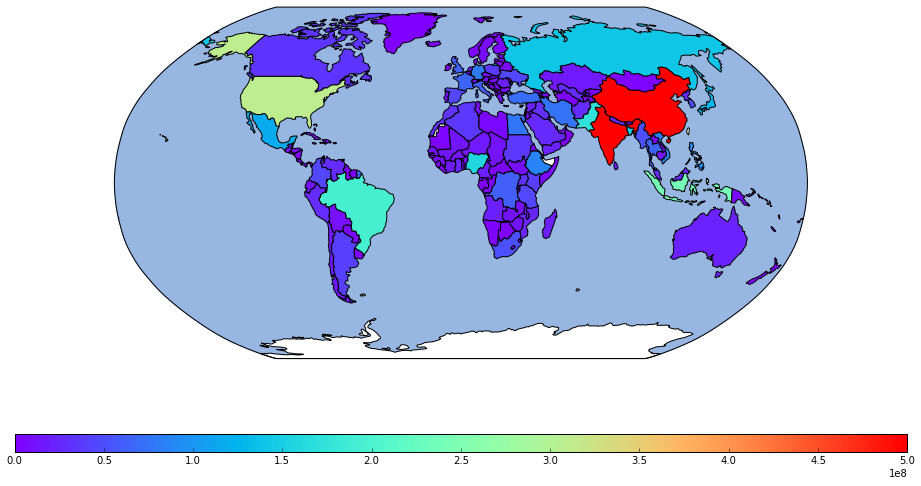

In [10]:
plot_map(countries, 'population', max_value=.5e+9)

In [11]:
temperature_data = pd.read_excel('./resources/cckp_historical_data_0.xls', 
                                 sheetname='Country_temperatureCRU')
iso = temperature_data['ISO_3DIGIT']
annual_mean_temperature = temperature_data['Annual_temp']
annual_mean_temperature.index = iso.values

In [12]:
add_country_property(countries, 'temperature', annual_mean_temperature)

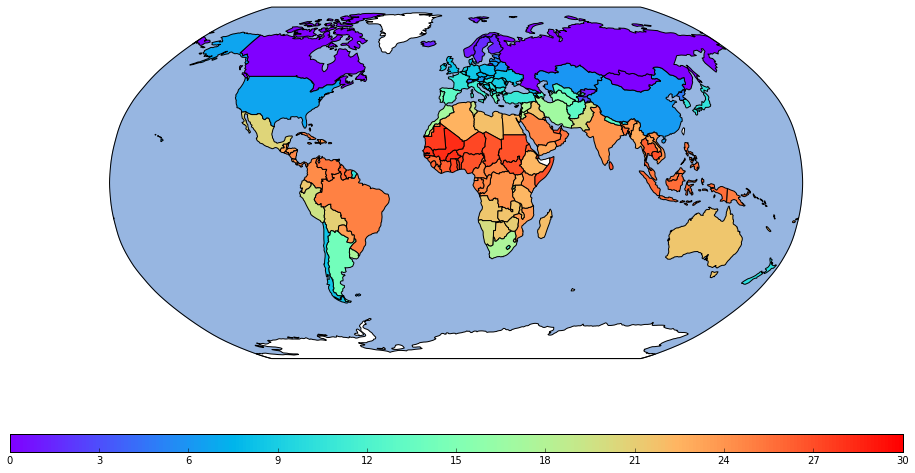

In [13]:
plot_map(countries, 'temperature', 'rainbow', min_value=0, max_value=30)

In [14]:
refugees_outgoing_data = pd.read_csv('./resources/sm.pop.refg.or_Indicator_en_csv_v2.csv', 
                                   header=1)
iso = refugees_outgoing_data['Country Code']
refugees_outgoing = refugees_outgoing_data['2012']
refugees_outgoing.index = iso
add_country_property(countries, 'refugees outgoing', refugees_outgoing)

refugees_incoming_data = pd.read_csv('./resources/sm.pop.refg_Indicator_en_csv_v2.csv', 
                                        header=1)
iso = refugees_incoming_data['Country Code']
refugees_incoming = refugees_incoming_data['2012']
refugees_incoming.index = iso
add_country_property(countries, 'refugees incoming', refugees_incoming)

In [15]:
for country in countries:
    country.properties['net refugees'] = country.properties['refugees outgoing'] - country.properties['refugees incoming']

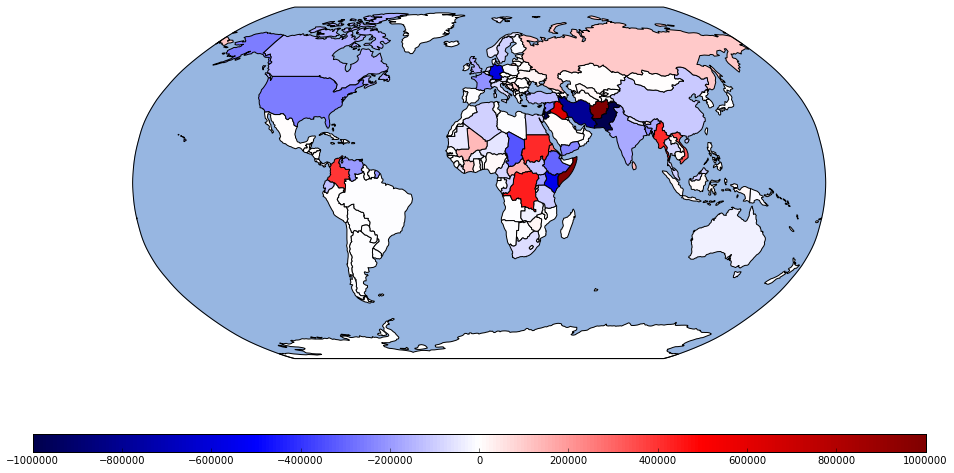

In [16]:
plot_map(countries, 'net refugees', colormap='seismic', min_value=-1e+6, max_value=1e+6)

In [17]:
for country in countries:
    country.properties['temperature'] = country.properties['temperature'] + 2

In [18]:
MOST_COMFORTABLE_TEMPERATURE = 18.0
FRACTION_LEAVING_PER_UNCOMFORTABLE_DEGREE = .0005
REFUGEE_INCREASE_PER_UNCOMFORTABLE_DEGREE = .2

In [19]:
for country in countries:
    temperature = country.properties['temperature']
    net_refugees = country.properties['net refugees']
    population = country.properties['population']
    uncomfortable_heat = max(0, temperature - MOST_COMFORTABLE_TEMPERATURE)
    regular_population_leaving = uncomfortable_heat * FRACTION_LEAVING_PER_UNCOMFORTABLE_DEGREE * population
    increased_refugee_stream = max(0, uncomfortable_heat * REFUGEE_INCREASE_PER_UNCOMFORTABLE_DEGREE * net_refugees)
    country.properties['net climate refugees'] = regular_population_leaving + increased_refugee_stream
    print("%s: %+.1f°C; %.f reg + %.f inc = %.f climate refugees" % (country.iso, 
                                                             uncomfortable_heat, 
                                                             regular_population_leaving,
                                                             increased_refugee_stream,
                                                             regular_population_leaving + increased_refugee_stream))

AFG: +0.0°C; 0 reg + 0 inc = 0 climate refugees
AGO: +5.5°C; 53867 reg + 0 inc = 53867 climate refugees
ALB: +0.0°C; 0 reg + 0 inc = 0 climate refugees
ARE: +10.8°C; 45692 reg + 0 inc = 45692 climate refugees
ARG: +0.0°C; 0 reg + 0 inc = 0 climate refugees
ARM: +0.0°C; 0 reg + 0 inc = 0 climate refugees
ATA: +0.0°C; nan reg + 0 inc = nan climate refugees
ATF: +0.0°C; nan reg + 0 inc = nan climate refugees
AUS: +5.5°C; 60661 reg + 0 inc = 60661 climate refugees
AUT: +0.0°C; 0 reg + 0 inc = 0 climate refugees
AZE: +0.0°C; 0 reg + 0 inc = 0 climate refugees
BDI: +4.3°C; 19694 reg + 26919 inc = 46613 climate refugees
BEL: +0.0°C; 0 reg + 0 inc = 0 climate refugees
BEN: +11.5°C; 54499 reg + 0 inc = 54499 climate refugees
BFA: +12.2°C; 94612 reg + 0 inc = 94612 climate refugees
BGD: +9.5°C; 715648 reg + 0 inc = 715648 climate refugees
BGR: +0.0°C; 0 reg + 0 inc = 0 climate refugees
BHS: +9.1°C; 1634 reg + 288 inc = 1922 climate refugees
BIH: +0.0°C; 0 reg + 0 inc = 0 climate refugees
BLR: +0

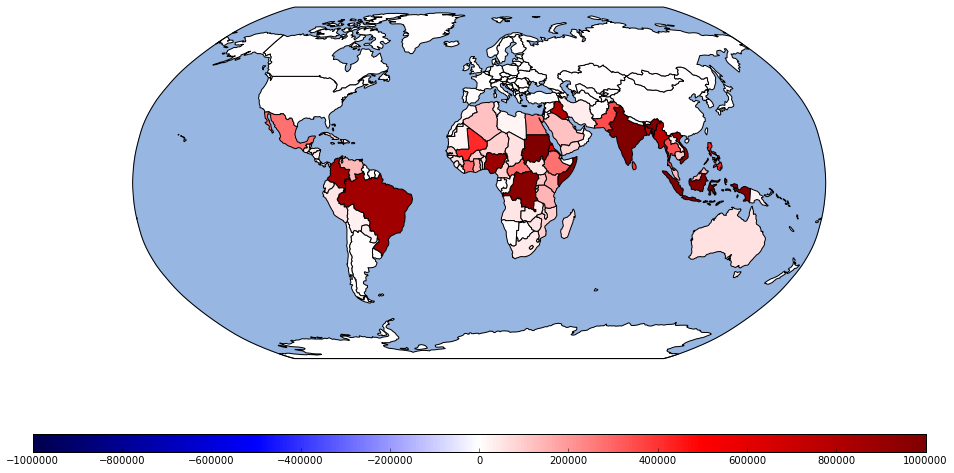

In [20]:
plot_map(countries, 'net climate refugees', max_value=1e6, min_value = -1e6, colormap='seismic')

In [21]:
def add_up(countries, property_to_add_up):
    total = 0
    for country in countries:
        if math.isfinite(country.properties[property_to_add_up]):
            total += country.properties[property_to_add_up]
    if total > 1e5:
        print("Total %s: %.2f millions." % (property_to_add_up, total/1e6))
    else:
        print("Total %s: %.f." % (property_to_add_up, total))
    return total

In [22]:
total_climate_refugees = add_up(countries, 'net climate refugees')

Total net climate refugees: 23.71 millions.


In [23]:
economic_data = pd.read_csv('./resources/d67eb1a5-9d13-4a2e-ae73-c61544832c1c_Data.csv', 
                            header=0, na_values='..')
gdp_section = economic_data[economic_data[:]['Series Code'] == 'NY.GDP.PCAP.CD']
gdp = pd.Series(index=gdp_section['Country Code'].values, data=gdp_section['2012 [YR2012]'].values)

In [24]:
add_country_property(countries, 'gdp per capita', gdp)

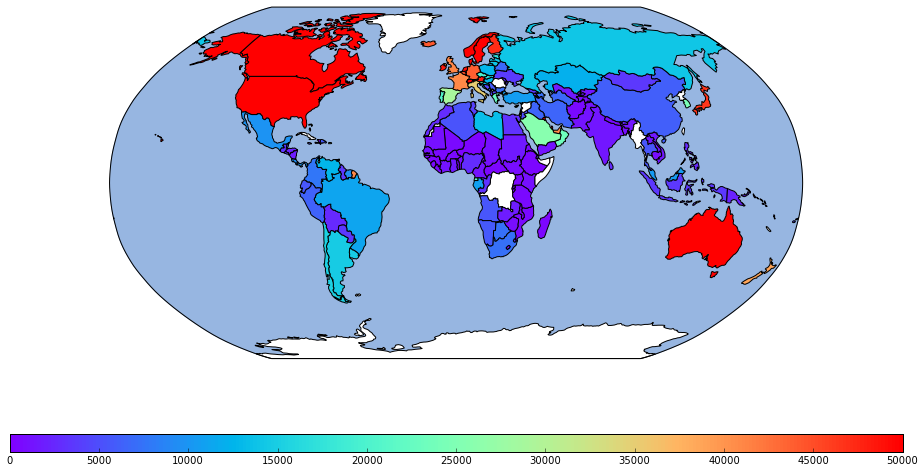

In [25]:
plot_map(countries, 'gdp per capita', max_value=50000)

In [26]:
CONFLICT_INTENSIFICATION_FACTOR = .01
GENEROSITY_FACTOR = 1e-9
POVERTY_LIMIT = 12000

In [27]:
while add_up(countries, 'net climate refugees') > 0:
    for country in countries:
        temperature = country.properties['temperature']
        net_refugees = country.properties['net refugees']
        gdp_per_capita = country.properties['gdp per capita']
        population = country.properties['population']
        more_of_the_same_refugees = min(0, net_refugees) * CONFLICT_INTENSIFICATION_FACTOR
        share_the_wealth_refugees = (-1) * max(0, gdp_per_capita - POVERTY_LIMIT) * population * GENEROSITY_FACTOR
        refugees_incoming = more_of_the_same_refugees + share_the_wealth_refugees
        if math.isfinite(refugees_incoming):
            country.properties['net climate refugees'] += refugees_incoming

Total net climate refugees: 23.71 millions.
Total net climate refugees: 23.54 millions.
Total net climate refugees: 23.38 millions.
Total net climate refugees: 23.22 millions.
Total net climate refugees: 23.05 millions.
Total net climate refugees: 22.89 millions.
Total net climate refugees: 22.72 millions.
Total net climate refugees: 22.56 millions.
Total net climate refugees: 22.39 millions.
Total net climate refugees: 22.23 millions.
Total net climate refugees: 22.06 millions.
Total net climate refugees: 21.90 millions.
Total net climate refugees: 21.74 millions.
Total net climate refugees: 21.57 millions.
Total net climate refugees: 21.41 millions.
Total net climate refugees: 21.24 millions.
Total net climate refugees: 21.08 millions.
Total net climate refugees: 20.91 millions.
Total net climate refugees: 20.75 millions.
Total net climate refugees: 20.58 millions.
Total net climate refugees: 20.42 millions.
Total net climate refugees: 20.26 millions.
Total net climate refugees: 20.0

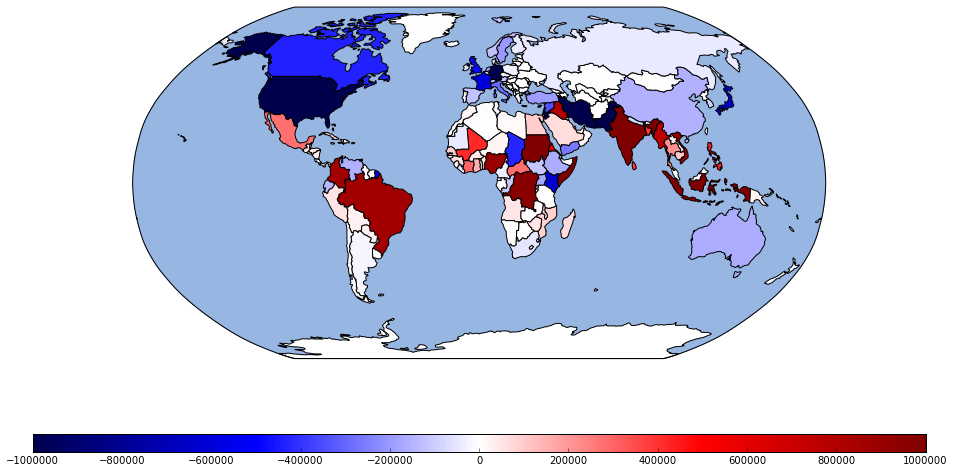

In [28]:
plot_map(countries, 'net climate refugees', max_value=1e6, min_value = -1e6, colormap='seismic')

#Vielen Dank.